# Tutorial: Tensorflow and Keras 
## CS175 Discussion #3,  Jan. 24th, 2018
Author: [Eric Nalisnick](http://www.ics.uci.edu/~enalisni/)

### Goals of this Lesson
- Introduce...
    - Tensorflow
    - Keras (using Tensorflow backend)
    
- Implement... 
    - Logistic Regression
    - Feedforward Neural Network

### References 
- [*Tensorflow*: Getting Started](https://www.tensorflow.org/get_started/get_started) 
- ["Hello world" in Keras](https://github.com/fastforwardlabs/keras-hello-world/blob/master/kerashelloworld.ipynb)
- [*Neural Networks and Deep Learning* by Michael Nielsen](http://neuralnetworksanddeeplearning.com/)

## 0.  Python Preliminaries
As usual, first we need to import Numpy, Pandas, MatPlotLib...

In [1]:
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
%matplotlib inline

I've created two functions that we'll use later to visualize which datapoints are being assigned to which classes.  They are a bit messy and not essential to the material so don't worry about understanding them.  I'll be happy to explain them to anyone interested during office hours.  

In [2]:
from matplotlib.colors import ListedColormap

# A somewhat complicated function to make pretty plots
def plot_classification_data(data1, data2, beta, logistic_flag=False):
    def logistic(z): return 1./(1+np.exp(-z))
    
    plt.figure()
    grid_size = .2
    features = np.vstack((data1, data2))
    # generate a grid over the plot
    x_min, x_max = features[:, 0].min() - .5, features[:, 0].max() + .5
    y_min, y_max = features[:, 1].min() - .5, features[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_size), np.arange(y_min, y_max, grid_size))
    # color the grid based on the predictions 
    if logistic_flag:
        Z = logistic(np.dot(np.c_[xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape[0])], beta))
        colorbar_label=r"Value of f($X \beta)$"
    else:
        Z = np.dot(np.c_[xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape[0])], beta)
        colorbar_label=r"Value of $X \beta$"
    Z = Z.reshape(xx.shape)
    background_img = plt.pcolormesh(xx, yy, Z, cmap=plt.cm.coolwarm)
    
    # Also plot the training points
    plt.scatter(class1_features[:, 0], class1_features[:, 1], c='b', edgecolors='k', s=70)
    plt.scatter(class2_features[:, 0], class2_features[:, 1], c='r', edgecolors='k', s=70)
    plt.title('Data with Class Prediction Intensities')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    color_bar = plt.colorbar(background_img, orientation='horizontal')
    color_bar.set_label(colorbar_label)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.show()

# Another messy looking function to make pretty plots of basketball courts
def visualize_court(log_reg_model, court_image = './data/nba_experiment/nba_court.png'):
    two_class_cmap = ListedColormap(['#FFAAAA', '#AAFFAA']) # light red for miss, light green for make
    x_min, x_max = 0, 50 #width (feet) of NBA court
    y_min, y_max = 0, 47 #length (feet) of NBA half-court
    grid_step_size = 0.2
    grid_x, grid_y = np.meshgrid(np.arange(x_min, x_max, grid_step_size), np.arange(y_min, y_max, grid_step_size))
    grid_predictions = log_reg_model.predict(np.c_[grid_x.ravel(), grid_y.ravel()])
    grid_predictions = grid_predictions.reshape(grid_x.shape)
    fig, ax = plt.subplots()
    court_image = plt.imread(court_image)
    ax.imshow(court_image, interpolation='bilinear', origin='lower',extent=[x_min,x_max,y_min,y_max])
    ax.imshow(grid_predictions, cmap=two_class_cmap, interpolation = 'nearest',
              alpha = 0.60, origin='lower',extent=[x_min,x_max,y_min,y_max])
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title( "Make / Miss Prediction Boundaries" )
    plt.show()

In [3]:
### function for shuffling the data and labels
def shuffle_in_unison(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    
### calculate classification errors
# return a percentage: (number misclassified)/(total number of datapoints)
def calc_classification_error(predictions, class_labels):
    n = predictions.size
    num_of_errors = 0.
    for idx in range(n):
        if (predictions[idx] >= 0.5 and class_labels[idx]==0) or (predictions[idx] < 0.5 and class_labels[idx]==1):
            num_of_errors += 1
    return num_of_errors/n

## 1.  Tensorflow

[Tensorflow](https://www.tensorflow.org/) is a library for computation on symbolic graphs.  Instead of defining variables with specific values and operations that execute immediately, in Tensorflow, we first define variables and operations on them---the computation graph.  Once the graph is defined, we can execute it for particular values.  First, let's import the library...  

In [4]:
import tensorflow as tf

Next, let's define a (very simple) computation graph...

In [5]:
X = tf.placeholder(dtype="float", shape=[None, 1])
Y = X**2

Now let's execute the graph...

In [6]:
# sample some random numbers
input_value = np.random.normal(size=(5,1))
print("Input Value (X):")
print(input_value)

# run the computation graph
with tf.Session() as s:
    y_output = s.run(fetches=Y, feed_dict={X: input_value})

print("\nOutput Value (Y = X^2):")
print(y_output)

Input Value (X):
[[-1.08187044]
 [-1.45501181]
 [ 1.40485965]
 [ 0.62872809]
 [ 0.56668347]]

Output Value (Y = X^2):
[[ 1.17044365]
 [ 2.11705947]
 [ 1.97363067]
 [ 0.39529902]
 [ 0.32113016]]


## 2.  Automatic Differentiation in Tensorflow

A big benefit of building a computation graph is that we have some data structure that tells us the sequence of operations applied to a variable.  Then, given some lookup table of derivatives, it's easy to programatically apply [the chain rule](https://en.wikipedia.org/wiki/Chain_rule), replacing each operations with its derivative.  This allows Tensorflow to perform what's called [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation).  Let's look at an example...    

In [7]:
X = tf.placeholder(dtype="float", shape=[None, 1])
Y = X**2
Z = tf.gradients(ys = Y, xs = X)

In [8]:
# sample some random numbers
input_value = np.random.normal(size=(5,1))
print("Input Value (X):")
print(input_value)

# run the computation graph
with tf.Session() as s:
    # should return 2*X
    z_output = s.run(fetches=Z, feed_dict={X: input_value})[0]

print("\nOutput Value (Z = dY/dX = 2*X):")
print(z_output)

Input Value (X):
[[ 2.33155177]
 [ 1.560511  ]
 [ 0.94455169]
 [-0.68119052]
 [ 2.55746521]]

Output Value (Z = dY/dX = 2*X):
[[ 4.66310358]
 [ 3.12102199]
 [ 1.88910341]
 [-1.36238098]
 [ 5.11493063]]


## 3.  Logistic Regression in Tensorflow

Given this auto. diff. feature, it's no wonder that Tensorflow is widely used for machine learning: for gradient-based model training, all we need to do is define the 'forward' model and Tensorflow can derive the necessary gradient w.r.t the model parameters.  Now let's look at a full but simple example.  Recall the logistic regression model: $$ \hat{y}_{i} = f(\mathbf{x}_{i} \boldsymbol{\beta}) \ \  \text{ where } \ \ f(z) = 1/(1 + e^{-z})$$ and $\boldsymbol{\beta}$ is the vector of parameters we need to learn / estimate from the data $\{ (\mathbf{x}_{i}, y_{i}) \}$.  

We can define such a model in Tensorflow.  Let's start with the variables...

### Define Variables

In [9]:
n_dims = 3

# define feature vector
X = tf.placeholder(dtype="float", shape=[None, n_dims])

# define labels
Y = tf.placeholder(dtype="float", shape=[None, 1])

# define parameter vector
Beta = tf.Variable(tf.random_normal([n_dims, 1], stddev=.001))

And now let's define the model...

### Define Model

In [10]:
# squashing function to map to (0, 1)
def logistic_fn(z):
    return 1./(1. + tf.exp(-z))

# model definition
Y_hat = logistic_fn( tf.matmul(X, Beta) )

Now we move on to a new step: model optimization.  We could use the tf.gradients() function to get the derivatives and perform the update to $\boldsymbol{\beta}$ ourselves, but Tensorflow has high-level wrappers to perform updates.  Thus, we next define a loss function and an optimizer...

### Define Loss Function and Optimizer

In [11]:
# define cross-entropy loss function
loss_fn = tf.reduce_sum(-Y * tf.log(Y_hat) + -(1-Y) * tf.log(1-Y_hat))

# define stochastic gradient optimizer
learning_rate = 0.0001
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_fn, var_list=[Beta])

Lastly, let's train the model on the same simulated data used in the last dicsussion...

### Train on Artificial Data

In [12]:
# set the random number generator for reproducability
np.random.seed(182)

#### create artificial data
N = 400
D = 2

# Sample the features from a Multivariate Normal Dist.
mean1 = [13.,5.]
mean2 = [5.,5.]
covariance = [[13.,5.],[5.,13.]]
class1_features = np.random.multivariate_normal(mean1, covariance, int(N/2))
class2_features = np.random.multivariate_normal(mean2, covariance, int(N/2))
features = np.vstack((class1_features, class2_features))

# add column of ones for bias term
features = np.hstack((features,np.ones((N,1))))

# Set the class labels
class1_labels = [0]*int(N/2)
class2_labels = [1]*int(N/2)
class_labels = class1_labels+class2_labels

# shuffle the data
shuffle_in_unison(features, class_labels)
class_labels = np.array(class_labels)[np.newaxis].T

Now visualize the data with color-codes for each class...

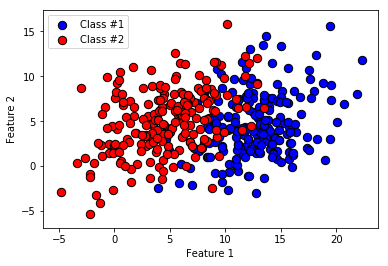

In [13]:
# visualize the data
plt.scatter(class1_features[:, 0], class1_features[:, 1], c='b', edgecolors='k', s=70, label="Class #1")
plt.scatter(class2_features[:, 0], class2_features[:, 1], c='r', edgecolors='k', s=70, label="Class #2")

plt.legend(loc=2)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

Epoch 20, Cross-Entropy Loss: 175.109
Epoch 40, Cross-Entropy Loss: 166.956
Epoch 60, Cross-Entropy Loss: 163.279
Epoch 80, Cross-Entropy Loss: 160.425
Epoch 100, Cross-Entropy Loss: 157.855
Epoch 120, Cross-Entropy Loss: 155.455
Epoch 140, Cross-Entropy Loss: 153.192
Epoch 160, Cross-Entropy Loss: 151.051
Epoch 180, Cross-Entropy Loss: 149.024
Epoch 200, Cross-Entropy Loss: 147.105
Epoch 220, Cross-Entropy Loss: 145.286
Epoch 240, Cross-Entropy Loss: 143.560
Epoch 260, Cross-Entropy Loss: 141.923
Epoch 280, Cross-Entropy Loss: 140.369
Epoch 300, Cross-Entropy Loss: 138.893

Training ended after 299 iterations, taking a total of 0.26 seconds.
Final Cross-Entropy Error: 138.89
Classification Error on Training Set: 14.75%


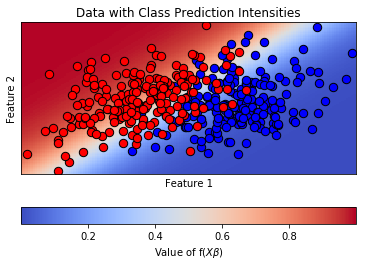

In [14]:
error = []

# run the computation graph
with tf.Session() as s:
    # this initializes the Beta variable (and any other tf.variable's)
    s.run(tf.global_variables_initializer())
    
    # Run Gradient Descent
    start_time = time.time()
    # loop until iteration threshold is reached
    for iter_idx in range(300):
    
        _, current_loss = s.run(fetches=[optimizer, loss_fn], feed_dict={X: features, Y: class_labels})
        
        error.append(current_loss)
        if (iter_idx+1) % 20 == 0:
            print("Epoch %d, Cross-Entropy Loss: %.3f" %(iter_idx+1, current_loss))
    
    end_time = time.time()
    print("\nTraining ended after %i iterations, taking a total of %.2f seconds." %(iter_idx, end_time-start_time))
    print("Final Cross-Entropy Error: %.2f" %(error[-1]))

    # compute error on training data
    predictions = s.run(fetches=Y_hat, feed_dict={X: features, Y: class_labels})
    print("Classification Error on Training Set: %.2f%%" %(calc_classification_error(predictions, class_labels) * 100))
    
    # get current value of regression parameters from comp. graph
    beta = s.run(fetches=Beta)

# generate the plot
plot_classification_data(class1_features, class2_features, beta, logistic_flag=True)

## 4.  Neural Networks in Tensorflow

Now let's consider a slightly more complicated model: a neural network.  Recall that neural networks are basically just a bunch of stacked logistic regression models: $$ \mathbf{h}_{i} = f(\mathbf{x}_{i} \boldsymbol{\beta}_{1}) \text{, } \ \ \hat{y}_{i} = f(\mathbf{h}_{i} \boldsymbol{\beta}_{2} + b)$$ where $f(\cdot)$ is again the logistic function and $\{\boldsymbol{\beta}_{1}, \boldsymbol{\beta}_{2}, b\}$ are the parameters.  

### Define Variables

In [15]:
n_input_dims = 3
n_hidden_dims = 20

# define feature vector
X = tf.placeholder(dtype="float", shape=[None, n_input_dims])

# define labels
Y = tf.placeholder(dtype="float", shape=[None, 1])

# define parameters
params = {'beta1': tf.Variable(tf.random_normal([n_input_dims, n_hidden_dims], stddev=.001)),
          'beta2': tf.Variable(tf.random_normal([n_hidden_dims, 1], stddev=.001)),
          'b': tf.Variable(tf.random_normal([1, 1], stddev=.001))
         }

### Define Model

In [16]:
# neural net model definition
h = logistic_fn( tf.matmul(X, params['beta1']) )
Y_hat = logistic_fn( tf.matmul(h, params['beta2']) + params['b'] )

### Define Loss Function and Optimizer

In [17]:
# define cross-entropy loss function
loss_fn = tf.reduce_sum(-Y * tf.log(Y_hat) + -(1-Y) * tf.log(1-Y_hat))

# define stochastic gradient optimizer
learning_rate = 0.001
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_fn, var_list=[params['beta1'], params['beta2'], params['b']])

### Train on Artificial Data

In [18]:
error = []

# run the computation graph
with tf.Session() as s:
    # this initializes the Beta variable (and any other tf.variable's)
    s.run(tf.global_variables_initializer())
    
    # Run Gradient Descent
    start_time = time.time()
    # loop until iteration threshold is reached
    for iter_idx in range(300):
    
        _, current_loss = s.run(fetches=[optimizer, loss_fn], feed_dict={X: features, Y: class_labels})
        
        error.append(current_loss)
        if (iter_idx+1) % 20 == 0:
            print("Epoch %d, Cross-Entropy Loss: %.3f" %(iter_idx+1, current_loss))
    
    end_time = time.time()
    print("\nTraining ended after %i iterations, taking a total of %.2f seconds." %(iter_idx, end_time-start_time))
    print("Final Cross-Entropy Error: %.2f" %(error[-1]))

    # compute error on training data
    predictions = s.run(fetches=Y_hat, feed_dict={X: features, Y: class_labels})
    print("Classification Error on Training Set: %.2f%%" %(calc_classification_error(predictions, class_labels) * 100))

Epoch 20, Cross-Entropy Loss: 275.077
Epoch 40, Cross-Entropy Loss: 191.196
Epoch 60, Cross-Entropy Loss: 134.667
Epoch 80, Cross-Entropy Loss: 121.543
Epoch 100, Cross-Entropy Loss: 115.238
Epoch 120, Cross-Entropy Loss: 111.201
Epoch 140, Cross-Entropy Loss: 108.356
Epoch 160, Cross-Entropy Loss: 106.275
Epoch 180, Cross-Entropy Loss: 104.725
Epoch 200, Cross-Entropy Loss: 103.553
Epoch 220, Cross-Entropy Loss: 102.657
Epoch 240, Cross-Entropy Loss: 101.964
Epoch 260, Cross-Entropy Loss: 101.424
Epoch 280, Cross-Entropy Loss: 100.998
Epoch 300, Cross-Entropy Loss: 100.862

Training ended after 299 iterations, taking a total of 0.26 seconds.
Final Cross-Entropy Error: 100.86
Classification Error on Training Set: 9.75%


## 5.  Logistic Regression in Keras

Next let's look at [Keras](https://keras.io/).  Keras acts as a wrapper around Tensorflow (and other auto-diff libraries such as [Theano](http://deeplearning.net/software/theano/)), giving the user higher-level abstractions for the layers that are typical in neural networks.  The user defines a model and adds layers to it sequentially.  

Now let's re-do our logistic regression model using Keras.  There's no need to define variables any long; we'll jump straight to the model definition...  

### Define Model

In [19]:
import keras.optimizers
from keras.models import Sequential 
from keras.layers import Dense, Activation 

model = Sequential() 
model.add( Dense(units=1, activation="sigmoid", input_dim=n_input_dims, use_bias=False) ) 

Using TensorFlow backend.


Like when using Tensorflow, we next define a loss function and an optimizer...

### Define Loss Function and Optimizer

In [20]:
sgd = keras.optimizers.SGD(lr=0.0001*400)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

Lastly, we can now train the model in just one line of code...

### Train on Artificial Data

In [21]:
train_log = model.fit(features, class_labels, batch_size=features.shape[0], epochs=300) 

Epoch 1/300
400/400 [==============================] - 0s 211us/step - loss: 2.7145 - acc: 0.3825
Epoch 2/300
400/400 [==============================] - 0s 10us/step - loss: 1.4824 - acc: 0.2250
Epoch 3/300
400/400 [==============================] - 0s 8us/step - loss: 1.0640 - acc: 0.3475
Epoch 4/300
400/400 [==============================] - 0s 7us/step - loss: 0.9392 - acc: 0.4325
Epoch 5/300
400/400 [==============================] - 0s 7us/step - loss: 0.8378 - acc: 0.4900
Epoch 6/300
400/400 [==============================] - 0s 7us/step - loss: 0.7536 - acc: 0.5325
Epoch 7/300
400/400 [==============================] - 0s 7us/step - loss: 0.6857 - acc: 0.5650
Epoch 8/300
400/400 [==============================] - 0s 6us/step - loss: 0.6320 - acc: 0.5750
Epoch 9/300
400/400 [==============================] - 0s 8us/step - loss: 0.5901 - acc: 0.6300
Epoch 10/300
400/400 [==============================] - 0s 7us/step - loss: 0.5575 - acc: 0.6675
Epoch 11/300
400/400 [==============

Epoch 86/300
400/400 [==============================] - 0s 8us/step - loss: 0.3843 - acc: 0.8325
Epoch 87/300
400/400 [==============================] - 0s 8us/step - loss: 0.3840 - acc: 0.8325
Epoch 88/300
400/400 [==============================] - 0s 8us/step - loss: 0.3837 - acc: 0.8325
Epoch 89/300
400/400 [==============================] - 0s 8us/step - loss: 0.3834 - acc: 0.8325
Epoch 90/300
400/400 [==============================] - 0s 7us/step - loss: 0.3831 - acc: 0.8325
Epoch 91/300
400/400 [==============================] - 0s 8us/step - loss: 0.3828 - acc: 0.8325
Epoch 92/300
400/400 [==============================] - 0s 7us/step - loss: 0.3825 - acc: 0.8325
Epoch 93/300
400/400 [==============================] - 0s 10us/step - loss: 0.3823 - acc: 0.8325
Epoch 94/300
400/400 [==============================] - 0s 11us/step - loss: 0.3820 - acc: 0.8325
Epoch 95/300
400/400 [==============================] - 0s 9us/step - loss: 0.3817 - acc: 0.8325
Epoch 96/300
400/400 [======

Epoch 170/300
400/400 [==============================] - 0s 7us/step - loss: 0.3632 - acc: 0.8450
Epoch 171/300
400/400 [==============================] - 0s 7us/step - loss: 0.3630 - acc: 0.8450
Epoch 172/300
400/400 [==============================] - 0s 7us/step - loss: 0.3628 - acc: 0.8450
Epoch 173/300
400/400 [==============================] - 0s 7us/step - loss: 0.3626 - acc: 0.8450
Epoch 174/300
400/400 [==============================] - 0s 6us/step - loss: 0.3624 - acc: 0.8450
Epoch 175/300
400/400 [==============================] - 0s 7us/step - loss: 0.3621 - acc: 0.8450
Epoch 176/300
400/400 [==============================] - 0s 7us/step - loss: 0.3619 - acc: 0.8450
Epoch 177/300
400/400 [==============================] - 0s 9us/step - loss: 0.3617 - acc: 0.8450
Epoch 178/300
400/400 [==============================] - 0s 7us/step - loss: 0.3615 - acc: 0.8450
Epoch 179/300
400/400 [==============================] - 0s 8us/step - loss: 0.3613 - acc: 0.8475
Epoch 180/300
400/40

Epoch 254/300
400/400 [==============================] - 0s 6us/step - loss: 0.3465 - acc: 0.8525
Epoch 255/300
400/400 [==============================] - 0s 8us/step - loss: 0.3464 - acc: 0.8525
Epoch 256/300
400/400 [==============================] - 0s 8us/step - loss: 0.3462 - acc: 0.8525
Epoch 257/300
400/400 [==============================] - 0s 9us/step - loss: 0.3460 - acc: 0.8550
Epoch 258/300
400/400 [==============================] - 0s 9us/step - loss: 0.3458 - acc: 0.8550
Epoch 259/300
400/400 [==============================] - 0s 11us/step - loss: 0.3456 - acc: 0.8550
Epoch 260/300
400/400 [==============================] - 0s 10us/step - loss: 0.3455 - acc: 0.8550
Epoch 261/300
400/400 [==============================] - 0s 9us/step - loss: 0.3453 - acc: 0.8550
Epoch 262/300
400/400 [==============================] - 0s 10us/step - loss: 0.3451 - acc: 0.8550
Epoch 263/300
400/400 [==============================] - 0s 9us/step - loss: 0.3449 - acc: 0.8550
Epoch 264/300
400

### Model Evaluation

In [22]:
predictions = model.predict(features)
print("Classification Error on Training Set: %.2f%%" %(calc_classification_error(predictions, class_labels) * 100))

Classification Error on Training Set: 14.00%


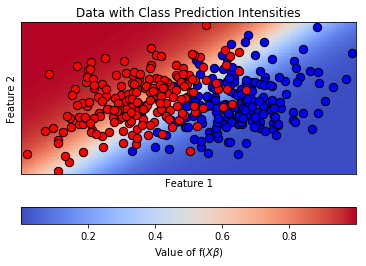

In [23]:
beta = model.layers[0].get_weights()

# generate the plot
plot_classification_data(class1_features, class2_features, beta, logistic_flag=True)

## 6.  Neural Networks in Keras

Finally, let's make a neural network in Keras....

### Define Model

In [24]:
model = Sequential() 

# add hidden layer
model.add( Dense(units=n_hidden_dims, activation="relu", input_dim=n_input_dims, use_bias=False) ) 

# add output layer
model.add( Dense(units=1, activation="sigmoid", input_dim=n_hidden_dims, use_bias=True) )

### Define Loss Function and Optimizer

In [25]:
sgd = keras.optimizers.SGD(lr=0.0001*400)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

### Train on Artificial Data

In [26]:
train_log = model.fit(features, class_labels, batch_size=features.shape[0], epochs=300) 

Epoch 1/300
400/400 [==============================] - 0s 258us/step - loss: 1.2272 - acc: 0.5000
Epoch 2/300
400/400 [==============================] - 0s 8us/step - loss: 0.5430 - acc: 0.6800
Epoch 3/300
400/400 [==============================] - 0s 9us/step - loss: 0.4379 - acc: 0.8050
Epoch 4/300
400/400 [==============================] - 0s 8us/step - loss: 0.4202 - acc: 0.8450
Epoch 5/300
400/400 [==============================] - 0s 8us/step - loss: 0.4143 - acc: 0.8475
Epoch 6/300
400/400 [==============================] - 0s 10us/step - loss: 0.4096 - acc: 0.8475
Epoch 7/300
400/400 [==============================] - 0s 9us/step - loss: 0.4056 - acc: 0.8475
Epoch 8/300
400/400 [==============================] - 0s 9us/step - loss: 0.4021 - acc: 0.8475
Epoch 9/300
400/400 [==============================] - 0s 8us/step - loss: 0.3993 - acc: 0.8450
Epoch 10/300
400/400 [==============================] - 0s 9us/step - loss: 0.3967 - acc: 0.8475
Epoch 11/300
400/400 [==============

Epoch 86/300
400/400 [==============================] - 0s 11us/step - loss: 0.3286 - acc: 0.8625
Epoch 87/300
400/400 [==============================] - 0s 10us/step - loss: 0.3281 - acc: 0.8625
Epoch 88/300
400/400 [==============================] - 0s 10us/step - loss: 0.3276 - acc: 0.8625
Epoch 89/300
400/400 [==============================] - 0s 8us/step - loss: 0.3272 - acc: 0.8625
Epoch 90/300
400/400 [==============================] - 0s 8us/step - loss: 0.3267 - acc: 0.8650
Epoch 91/300
400/400 [==============================] - 0s 8us/step - loss: 0.3263 - acc: 0.8650
Epoch 92/300
400/400 [==============================] - 0s 10us/step - loss: 0.3259 - acc: 0.8650
Epoch 93/300
400/400 [==============================] - 0s 9us/step - loss: 0.3254 - acc: 0.8650
Epoch 94/300
400/400 [==============================] - 0s 12us/step - loss: 0.3250 - acc: 0.8650
Epoch 95/300
400/400 [==============================] - 0s 8us/step - loss: 0.3246 - acc: 0.8650
Epoch 96/300
400/400 [===

Epoch 170/300
400/400 [==============================] - 0s 8us/step - loss: 0.2989 - acc: 0.8775
Epoch 171/300
400/400 [==============================] - 0s 8us/step - loss: 0.2986 - acc: 0.8775
Epoch 172/300
400/400 [==============================] - 0s 9us/step - loss: 0.2984 - acc: 0.8775
Epoch 173/300
400/400 [==============================] - 0s 9us/step - loss: 0.2981 - acc: 0.8775
Epoch 174/300
400/400 [==============================] - 0s 10us/step - loss: 0.2979 - acc: 0.8775
Epoch 175/300
400/400 [==============================] - 0s 9us/step - loss: 0.2976 - acc: 0.8775
Epoch 176/300
400/400 [==============================] - 0s 10us/step - loss: 0.2974 - acc: 0.8775
Epoch 177/300
400/400 [==============================] - 0s 12us/step - loss: 0.2971 - acc: 0.8775
Epoch 178/300
400/400 [==============================] - 0s 10us/step - loss: 0.2969 - acc: 0.8775
Epoch 179/300
400/400 [==============================] - 0s 10us/step - loss: 0.2966 - acc: 0.8775
Epoch 180/300
4

Epoch 254/300
400/400 [==============================] - 0s 8us/step - loss: 0.2797 - acc: 0.8825
Epoch 255/300
400/400 [==============================] - 0s 10us/step - loss: 0.2795 - acc: 0.8825
Epoch 256/300
400/400 [==============================] - 0s 9us/step - loss: 0.2793 - acc: 0.8825
Epoch 257/300
400/400 [==============================] - 0s 8us/step - loss: 0.2791 - acc: 0.8825
Epoch 258/300
400/400 [==============================] - 0s 9us/step - loss: 0.2789 - acc: 0.8825
Epoch 259/300
400/400 [==============================] - 0s 17us/step - loss: 0.2788 - acc: 0.8825
Epoch 260/300
400/400 [==============================] - 0s 7us/step - loss: 0.2786 - acc: 0.8825
Epoch 261/300
400/400 [==============================] - 0s 9us/step - loss: 0.2784 - acc: 0.8825
Epoch 262/300
400/400 [==============================] - 0s 5us/step - loss: 0.2782 - acc: 0.8825
Epoch 263/300
400/400 [==============================] - 0s 7us/step - loss: 0.2781 - acc: 0.8825
Epoch 264/300
400/

### Model Evaluation

In [27]:
predictions = model.predict(features)
print("Classification Error on Training Set: %.2f%%" %(calc_classification_error(predictions, class_labels) * 100))

Classification Error on Training Set: 11.50%


# Experiments

## 4.  Dataset #1: NBA Shot Outcomes

The first real dataset we'll tackle is one describing the location and outcome of shots taken in professional basketball games.  Let's use Pandas to load and examine the data.    

In [28]:
nba_shot_data = pd.read_csv('./data/nba_experiment/NBA_xy_features.csv')
nba_shot_data.head()

,x_Coordinate,y_Coordinate,shot_outcome
0,26.0,32.0,0.0
1,25.0,24.0,0.0
2,25.0,6.0,1.0
3,40.0,7.0,1.0
4,12.0,13.0,1.0


In [29]:
# split data into train and test
train_set_size = int(.80*len(nba_shot_data))
train_features = nba_shot_data.ix[:train_set_size,['x_Coordinate','y_Coordinate']]
test_features = nba_shot_data.ix[train_set_size:,['x_Coordinate','y_Coordinate']]
train_class_labels = nba_shot_data.ix[:train_set_size,['shot_outcome']]
test_class_labels = nba_shot_data.ix[train_set_size:,['shot_outcome']]

//anaconda/envs/cs175/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:
model = Sequential() 
model.add( Dense(units=n_hidden_dims, activation="relu", input_dim=train_features.shape[1]) ) 
model.add( Dense(units=1, activation="sigmoid", input_dim=n_hidden_dims) )

adam = keras.optimizers.Adam(lr=0.0003)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/5
450031/450031 [==============================] - 43s 96us/step - loss: 0.6847 - acc: 0.5780
Epoch 2/5
450031/450031 [==============================] - 42s 94us/step - loss: 0.6764 - acc: 0.5895
Epoch 3/5
450031/450031 [==============================] - 43s 95us/step - loss: 0.6745 - acc: 0.5965
Epoch 4/5
450031/450031 [==============================] - 39s 87us/step - loss: 0.6730 - acc: 0.5994
Epoch 5/5
450031/450031 [==============================] - 41s 91us/step - loss: 0.6718 - acc: 0.6014
Training ended after 208.59 seconds.

Classification Error on the Test Set: 39.91%
Baseline Error: 45.79%


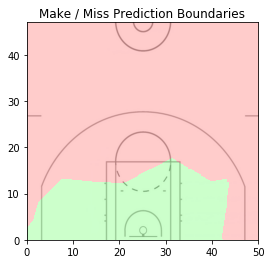

In [31]:
#Train it
start_time = time.time()

train_log = model.fit(train_features, np.ravel(train_class_labels), epochs=5) 

end_time = time.time()
print("Training ended after %.2f seconds." %(end_time-start_time))

# compute the classification error on training data
predictions = model.predict(test_features)
print("\nClassification Error on the Test Set: %.2f%%" %(calc_classification_error(predictions, np.array(test_class_labels)) * 100))

# compute the baseline error since the classes are imbalanced
print("Baseline Error: %.2f%%" %(np.sum(test_class_labels)/len(test_class_labels)*100))

# visualize the boundary on the basketball court
visualize_court(model)

## 5.  Dataset #3: 20 News Groups

Train a Keras neural network on 20 News Groups...

In [32]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

# use SciKit Learn's loading methods
categories = ['soc.religion.christian', 'alt.atheism']
train_20ng = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=categories)
test_20ng = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=categories)

# transform the text into word counts
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
train_vectors = vectorizer.fit_transform(train_20ng.data)
test_vectors = vectorizer.transform(test_20ng.data)

train_targets = train_20ng.target
test_targets = test_20ng.target

Build model...

In [33]:
model = Sequential() 
model.add( Dense(units=n_hidden_dims, activation="relu", input_dim=train_vectors.shape[1]) ) 
model.add( Dense(units=1, activation="sigmoid", input_dim=n_hidden_dims) )

adam = keras.optimizers.Adam(lr=0.0003)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

Train model...

In [34]:
#Train it
start_time = time.time()
model.fit(train_vectors, train_targets, epochs=10)
end_time = time.time()
print("Training ended after %.2f seconds." %(end_time-start_time))

# compute the classification error on training data
predictions = model.predict(test_vectors)
print("\nClassification Error on the Test Set: %.2f%%" %(calc_classification_error(predictions, test_targets) * 100))

# compute the baseline error since the classes are imbalanced
print("Baseline Error: %.2f%%" %(100 - sum(test_targets)*100./len(test_targets)))

Epoch 1/10
1079/1079 [==============================] - 0s 262us/step - loss: 0.7144 - acc: 0.5079
Epoch 2/10
1079/1079 [==============================] - 0s 128us/step - loss: 0.6595 - acc: 0.6154
Epoch 3/10
1079/1079 [==============================] - 0s 129us/step - loss: 0.6241 - acc: 0.6895
Epoch 4/10
1079/1079 [==============================] - 0s 131us/step - loss: 0.5895 - acc: 0.7414
Epoch 5/10
1079/1079 [==============================] - 0s 139us/step - loss: 0.5551 - acc: 0.7970
Epoch 6/10
1079/1079 [==============================] - 0s 144us/step - loss: 0.5226 - acc: 0.8369
Epoch 7/10
1079/1079 [==============================] - 0s 140us/step - loss: 0.4914 - acc: 0.8582
Epoch 8/10
1079/1079 [==============================] - 0s 141us/step - loss: 0.4607 - acc: 0.8869
Epoch 9/10
1079/1079 [==============================] - 0s 142us/step - loss: 0.4305 - acc: 0.9036
Epoch 10/10
1079/1079 [==============================] - 0s 147us/step - loss: 0.4046 - acc: 0.9138
Training 